## PA4.2  Cycle gans with tensorflow (65 marks)
### In this notebook we use [CycleGAN](https://arxiv.org/abs/1703.10593) to generate images of horses from zebras and vice versa.




[All code blocks should already have been run and the outputs should be visible in order to be graded]


Roll number:

# Important Instructions

- You are allowed to (encouraged to) use either colabs or kaggle notebooks.
- Please do not do this on your local machine as it will take unnecessarily long times to run, and you will have to deal with the issues of storing models.
- There are certain code blocks that have been partially implemented, in such blocks there are places where you will find a  "..." you are supposed to fill in the "..." with your code.
- In other code blocks you have to implement the whole block, please do so in the space provided.

The following link: https://colab.research.google.com/github/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/CycleGAN.ipynb should lead you to an abstration of what you will be doing, the only difference is that you will be coding this on Cyclegans on your own.


now lets get started


# import libraries

Do not include extra imports, you should be able to complete this assignment with the following imports alone, if you think you need more, please ask reahc out via slack.

In [ ]:
!pip install tensorflow_addons

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model, Input
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

AUTOTUNE = tf.data.AUTOTUNE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load dataset (2.5 marks)

For this paper will be using the horse2zebra dataset. You can find this dataset and similar ones [here](https://www.tensorflow.org/datasets/catalog/cycle_gan).

You can go ahead and apply  any sort of preprocessing u want on the images, data augmentation works too, since this exact the image translation is also being done in the paper, you may want to refer to the [paper](https://arxiv.org/abs/1703.10593), itself for some help.

In [ ]:
# start of by loading the dataset itself, and then divide the dataset into training and testing.

dataset = tfds.load('cycle_gan/horse2zebra', split=['trainA', 'trainB', 'testA', 'testB'])

train_horses, train_zebras, test_horses, test_zebras = dataset
# print(train_horses)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1067 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompleteES8RYW/cycle_gan-trainA.tfrecord*...…

Generating trainB examples...:   0%|          | 0/1334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompleteES8RYW/cycle_gan-trainB.tfrecord*...…

Generating testA examples...:   0%|          | 0/120 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompleteES8RYW/cycle_gan-testA.tfrecord*...:…

Generating testB examples...:   0%|          | 0/140 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompleteES8RYW/cycle_gan-testB.tfrecord*...:…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0. Subsequent calls will reuse this data.


In [ ]:
# feel free to use these variables to change the size of the images (these are default values as per the paper)
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Preprocessing (2.5 marks)

In [ ]:
# Use this code block to perform the necessary preprocessing for your data.
# You are encouraged to make your code modular by defining functions for preprocessing, and then apply these functions in subsequent code blocks.


def preprocess_image(image):
    # image = image_dict['image']
    image = tf.image.resize(image, [256, 256])
    image = normalize_image(image)
    return image


# Normalise the images (2.5 marks)

In [ ]:
def normalize_image(image):

    image = tf.cast(image, tf.float32)
    image = (image / (IMG_HEIGHT / 2)) - 1
    return image

def preprocess_image(image):
    # image = image_dict['image']
    image = tf.image.resize(image, [256, 256])
    image = normalize_image(image)
    return image

train_horses_preprocessed = []
for item in train_horses:
    train_horses_preprocessed.append(preprocess_image(item['image']))

train_zebras_preprocessed = []
for item in train_zebras:
    train_zebras_preprocessed.append(preprocess_image(item['image']))

test_horses_preprocessed = []
for item in test_horses:
    test_horses_preprocessed.append(preprocess_image(item['image']))

test_zebras_preprocessed = []
for item in test_zebras:
    test_zebras_preprocessed.append(preprocess_image(item['image']))

train_horses_dataset = tf.data.Dataset.from_tensor_slices(train_horses_preprocessed)
train_zebras_dataset = tf.data.Dataset.from_tensor_slices(train_zebras_preprocessed)

train_horses_dataset = train_horses_dataset.batch(BATCH_SIZE)
train_zebras_dataset = train_zebras_dataset.batch(BATCH_SIZE)



In [ ]:
train_horses_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

Ideally you could create iter objects to traverse through the images but you can choose to go with your own implementation, and deviatef rom the template if you want to.

In [ ]:
# create iter object here
train_horses_iter = iter(train_horses_preprocessed)
train_zebras_iter = iter(train_zebras_preprocessed)
test_horses_iter = iter(test_horses_preprocessed)
test_zebras_iter = iter(test_zebras_preprocessed)


# Visualize the images

visualize the images and check if the preprocesisng is being done correctly

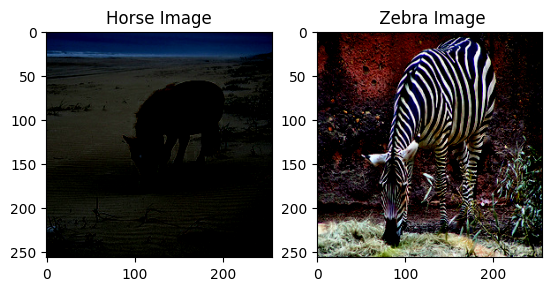

In [ ]:
horse_image = next(train_horses_iter)

zebra_image = next(train_zebras_iter)

plt.subplot(1, 2, 1)
plt.imshow(horse_image)
plt.title("Horse Image")

plt.subplot(1, 2, 2)
plt.imshow(zebra_image)
plt.title(" Zebra Image")

plt.show()

# The architecture

Now comes the point where we make our own architecture, the paper itself employs a basic cycle gans architecture, featuring 2 generators and 2 discriminators, and in the implementation it uses the gen and disrim architectures from the pix2pix gans model, however we will not be doing this, we will be coding our own architectures, it will still be 2 generators and 2 discrimiantors but not the ones being used in pix2pix.

# Sampling (2.5)

Before we even get to the architectures of the models, we need to worry about the sampling, we need to make sure that the images are being  interpreted by the neural networks correctly, what I mean by this is, that we need to implement some sort of sampling functions that do the following:

1. Compresses images to extract essential features lets call this the downsmapling function.
2. Reconstructs these images from features into the target domain, enabling unpaired image-to-image translation, lets call this the upsampling function

both of these funciton will be used in your neural networks, they have been implemented below.

YOU HAVE TO FILL IN THE "..." IN THE CODE BLOCKS BELOW, with whatever you feel fits best, once again the paper might be of help here.

In [ ]:
def downsample(filters, size, apply_norm=True, norm_type='instancenorm'):

    # Initialize weights with a mean and standard deviation of your choosing
    initializer = tf.random_normal_initializer(0, 0.05)

    # Create a sequential model to stack layers
    result = tf.keras.Sequential()

    # Add a 2D Convolution layer for downsampling, with specified filters, size, and stride, without bias
    result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    # Conditionally apply normalization
    if apply_norm:
        if norm_type == 'instancenorm':  # Check if normalization type is instance normalization
            # Add instance normalization layer
            result.add(tfa.layers.InstanceNormalization())

    # Add LeakyReLU or RelU (your choice to make) for non-linearity while allowing some gradients to flow for negative values
    result.add(tf.keras.layers.LeakyReLU())
    return result


def upsample(filters, size, apply_dropout=False):

    # Initialize weights with a mean and standard deviation of your choosing
    initializer = tf.random_normal_initializer(0, 0.05)

    # Create a sequential model to stack layers
    result = tf.keras.Sequential()

    # Add a 2D Transposed Convolution layer for upsampling, with specified filters, size, and stride, without bias
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    # Add instance normalization layer
    result.add(tfa.layers.InstanceNormalization())

    # Conditionally apply dropout for regularization
    if apply_dropout:
        # Add dropout layer with a dropout rate of 0.5
        result.add(layers.Dropout(0.5))

    # Add LeakyReLU or RelU (your choice to make) for non-linearity to ensure positive activations
    result.add(tf.keras.layers.LeakyReLU())
    return result


# Generator Architecture (10 marks)

You will be implementing the generator architecture of U-Net, which is a popular architecture for image-to-image translation tasks. The architecture is as follows:

1. Downsampling: The generator first downsamples the input image and extracts features from it.
2. Bottleneck: The features are then passed through a bottleneck layer.
3. Upsampling: The features are then upsampled to generate the output image.


In [ ]:
def unet_generator(output_channels, norm_type='instancenorm'):

    # print("inside unet")
    # 1. Define the input layer to accept images of shape (Height, Width, 3)
    inputs = Input(shape=[None, None, 3])

    # 2. Construct the downsampling stack
    down_stack = [
        downsample(64, 4, apply_norm=False), # Starting without normalization for the first layer
        # Add additional downsample layers with increasing filters and normalization
        downsample(128, 4, norm_type),
        downsample(256, 4, norm_type),
        downsample(512, 4, norm_type),
    ]

    # 3. Construct the upsampling stack
    up_stack = [
        upsample(512, 4, apply_dropout=True), # Starting with dropout layers for regularization
        # Add additional upsample layers with decreasing filters
        upsample(256, 4, apply_dropout=True),
        upsample(128, 4, apply_dropout=True),
        upsample(64, 4, apply_dropout=True),

    ]

    # 4. Define the final layer with a Conv2DTranspose to map to the desired output_channels with 'tanh' activation
    initializer = tf.random_normal_initializer(0 , 0.05) # Initialize with the same mean and std dev you used above
    last = layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')


    # Implement the forward pass: downsampling, skip connections, and upsampling
    # Remember to concatenate the corresponding downsample layer's output with the upsample layer's output for the skip connections
    concat = layers.Concatenate()

    inputs = Input(shape=[None, None, 3])
    x = inputs

    temp = []
    for i in range(len(down_stack)):
        x = down_stack[i](x)
        temp.append(x)

    temp_reversed = []
    for skip in reversed(temp[:-1]):
        temp_reversed.append(skip)

    for i in range(len(up_stack) - 1):
        x = up_stack[i](x)
        x = concat([x, temp_reversed[i]])

    x = last(x)


    return Model(inputs=inputs, outputs= x)  # Return the model instance

# Discriminator Architecture (10 marks)

The discriminator architecture is a PatchGAN discriminator, which is a popular discriminator architecture for image-to-image translation tasks. The architecture is as follows:

1. The discriminator downsamples the input image and extracts features from it.
2. The features are then passed through a bottleneck layer.
3. The features are then passed through a classification layer.



In [ ]:
def discriminator(norm_type='instancenorm', target=False):
    # 1. Initialize weights and define input layer for input images
    initializer = tf.random_normal_initializer(0, 0.05) # Initialize with the same mean and std dev you used above
    inp = Input(shape=[None, None, 3], name='input_image')

    x = inp

    # 2. Optionally concatenate target image if discriminator is conditional
    if target:
        tar = Input(shape=[None, None, 3], name='target_image')
        x = layers.concatenate([inp, tar])  # Combine input and target for conditional GAN

    # 3. Add downsampling layers to process the input (or combined input and target) images
    x = downsample(64, 4, False, norm_type)(x)  # Start with downsampling without normalization
    x = downsample(128, 4, True, norm_type)(x)  # Subsequent layers with normalization
    x = downsample(256, 4, True, norm_type)(x)


    # 4. Apply convolution with zero padding -> Conv2d -> normalization layers to refine the features before the final layer
    zero_pad1 =  tf.keras.layers.ZeroPadding2D()(x)
    conv =  tf.keras.layers.Conv2D(256, 4, strides=1, kernel_initializer=initializer)(zero_pad1)

    if norm_type == 'instancenorm':
        norm1 =  tf.keras.layers.BatchNormalization()(conv)

        leaky_relu = layers.LeakyReLU()(norm1)


    # 5. Add a final convolution layer without normalization

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)


    # Return model based on whether target image is part of the input
    if target:
        return Model(inputs=[inp, tar], outputs=last)
    else:
        return Model(inputs=inp, outputs=last)


In [ ]:
OUTPUT_CHANNELS = 3  # dont change unless u decided to make images grayscale in preprocessing (ideally u did not do that)

# declare the generators
generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# declare the discriminators
discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)


# Visualize (again)

Visualize the images latent space representation to check if the models are doing some sort of trnasformation (completely optional)

## Loss functions (5 marks)

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input and the target  pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

You are going to have to implement the following loss functions:

1. Discriminator loss
2. Generator loss
3. Identity loss
4. Cycle consistency loss

In [ ]:
# This line initializes a loss_obj object as an instance of TensorFlow's BinaryCrossentropy class, configured to operate on logits.
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):

    # Calculate the real loss using the loss object and the real and generated values

    temp1 = tf.ones(tf.shape(real))
    temp0 = tf.zeros(tf.shape(generated))

    real_loss = loss_obj(temp1, real)
    generated_loss = loss_obj(temp0, generated)


    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):

    # Calculate the loss between the generated images and a matrix of ones, using the loss object
    temp1 = tf.ones(tf.shape(generated))

    ans = loss_obj(temp1, generated)
    return ans

In [ ]:
def calc_cycle_loss(real_image, cycled_image):

  # Calculate the cycle consistency loss using the L1 norm (tf.reduce_mean and tf.abs will be useful here) also consider multiplying
  # the loss by some scalar factor (like 10) to give it more weight, as compared to the other losses.

  diff = tf.abs(cycled_image - real_image)
  temp = tf.reduce_mean(diff)
  final_loss = 10 * temp
  return final_loss

In [ ]:
def identity_loss(real_image, same_image):
  # Calculate the cycle consistency loss using the L1 norm (tf.reduce_mean and tf.abs will be useful here) also consider multiplying
  # the loss by some scalar factor (like 5) to give it less weight, as compared to the other losses.

  diff = tf.abs(same_image - real_image)
  temp = tf.reduce_mean(diff)
  final_loss = 5 * temp
  return final_loss

Initialize the optimizers for all the generators and the discriminators.

we will be using the good old adam optimizer, with the betas set to what they are rn.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints (Optional but highly recomended)

You can save the model checkpoints at regular intervals, so that you can resume training in case of a runtime failure. You can also use these checkpoints to test the model on new images without having to retrain it, point is you should save the model checkpoints, becuase training time for GANs is not quite long.


## Training the model (15 marks)

Now that we are done with the model and everything else, lets train the model, you can train the model for as many epochs as you want, the paper trains it for 200 epochs, that however is not possible, so you are reccomended to train the model to the point where you see some sort of transaltion in the images.

In most computationally restricted implementations, the model is trained for 5 to 10 epochs, and does show some signs of image translation. but this also depends on your architecture.

In [ ]:
EPOCHS = 8

In [ ]:
# Ideally implement a function right now to generate images, during training.
def generate_images(model, test_input):

    ans = model(test_input, training=False)
    return ans

The training loop consists of four main steps:

* Get the predictions (essentially a forward pass).
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [ ]:
@tf.function
def train_step(real_x, real_y):

  # The Set up for TensorFlow's automatic differentiation context, has already been done for you do not change it

  with tf.GradientTape(persistent=True) as tape:

    # what you have to do now is translate from domain X to Y and back to X, and from Y to X and back to Y, for cycle consistency
    # so train the generators for real and fake data, as per fucniton prototype.

    # code here

    # x to y to x
    # print("inside train")
    # print(real_x.shape)
    y = generator_g(real_x, training=True)
    # print("goes here")
    x = generator_f(y, training=True)

    # print("here??")


    # y to x to y
    x1 = generator_f(real_y, training=True)
    y1 = generator_g(x1, training=True)



    # Generates images in the same domain to enforce identity preservation.
    # so train the generators for real data, as per fucniton prototype.

    # code here
    # ?????????
    same_domain_x = generator_f(real_x, training=True)
    same_domain_y = generator_g(real_y, training=True)



    # Use the Discriminators to determine the what image is real and what is fake images.
    # so train the discriminators for real and fake data, as per fucniton prototype.

    # code here

    discr_x_real = discriminator_x(real_x, training=True)

    discr_y_real = discriminator_y(real_y, training=True)


    discr_x_fake = discriminator_x(x1, training=True)

    discr_y_fake = discriminator_y(y, training=True)





    # Calculates losses for generators and discriminators.
    # for your ease losses are given

    gen_g_loss = generator_loss(discr_y_fake)
    gen_f_loss = generator_loss(discr_x_fake)


    temp1 = calc_cycle_loss(real_x, x)
    temp2 = calc_cycle_loss(real_y, y)
    total_cycle_loss = temp1 + temp2

    temp3 = identity_loss(real_y, y)
    total_gen_g_loss = gen_g_loss + temp3 + total_cycle_loss

    temp4 = identity_loss(real_x, x)
    total_gen_f_loss = gen_f_loss + temp4 + total_cycle_loss


    temp5 = discriminator_loss(discr_x_real, discr_x_fake)
    disc_x_loss =  temp5

    temp6 = discriminator_loss(discr_y_real, discr_y_fake)
    disc_y_loss =  temp6


    # Computes gradients of losses and apply them to optimize the models accordingly (use and tape zip)
    # an example has been done below for generator_g

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))

    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss


In [ ]:
EPOCHS = 8

In [ ]:
for epoch in range(EPOCHS):
    # code for executing the loop should go here

    for (real_x, real_y) in zip(train_horses_dataset, train_zebras_dataset):
        # print(real_y)
        gen_g, gen_f, disc_x, disc_y = train_step(real_x, real_y)

    print("Epoch : ", epoch, "  Loss_gen_g : ", gen_g, "  Loss_gen_f : ", gen_f, "  Loss_disc_x : ", disc_x, "  Loss_disc_y : ", disc_y)


Epoch :  0   Loss_gen_g :  tf.Tensor(10.816767, shape=(), dtype=float32)   Loss_gen_f :  tf.Tensor(8.877662, shape=(), dtype=float32)   Loss_disc_x :  tf.Tensor(0.47848475, shape=(), dtype=float32)   Loss_disc_y :  tf.Tensor(0.5084158, shape=(), dtype=float32)
Epoch :  1   Loss_gen_g :  tf.Tensor(9.567307, shape=(), dtype=float32)   Loss_gen_f :  tf.Tensor(7.372035, shape=(), dtype=float32)   Loss_disc_x :  tf.Tensor(0.55532813, shape=(), dtype=float32)   Loss_disc_y :  tf.Tensor(0.46703732, shape=(), dtype=float32)
Epoch :  2   Loss_gen_g :  tf.Tensor(9.298411, shape=(), dtype=float32)   Loss_gen_f :  tf.Tensor(7.5456533, shape=(), dtype=float32)   Loss_disc_x :  tf.Tensor(0.58229613, shape=(), dtype=float32)   Loss_disc_y :  tf.Tensor(0.57523966, shape=(), dtype=float32)
Epoch :  3   Loss_gen_g :  tf.Tensor(9.057753, shape=(), dtype=float32)   Loss_gen_f :  tf.Tensor(7.7948685, shape=(), dtype=float32)   Loss_disc_x :  tf.Tensor(0.4593119, shape=(), dtype=float32)   Loss_disc_y :  tf

## Generation time


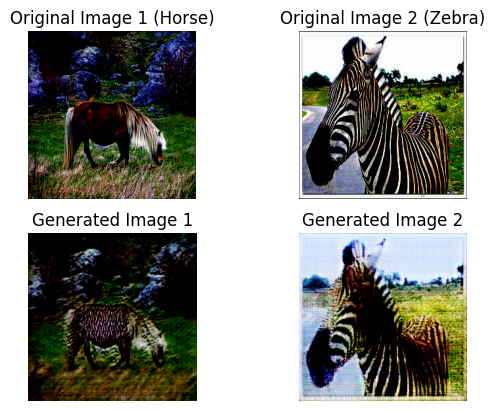

In [ ]:
plt.subplot(2, 2, 1)
plt.imshow(train_horses_preprocessed[39])
plt.title('Original Image 1 (Horse)')
plt.axis('off')


plt.subplot(2, 2, 2)
plt.imshow(train_zebras_preprocessed[72])
plt.title('Original Image 2 (Zebra)')
plt.axis('off')


image_1 = train_horses_preprocessed[39]
image_2 = train_zebras_preprocessed[72]

image_1 = tf.expand_dims(image_1, axis=0)
image_2 = tf.expand_dims(image_2, axis=0)

generated_image_1 = generator_g(image_1, training=False)[0]
generated_image_2 = generator_f(image_2, training=False)[0]

plt.subplot(2, 2, 3)
plt.imshow(generated_image_1.numpy())
plt.title('Generated Image 1')
plt.axis('off')


plt.subplot(2, 2, 4)
plt.imshow(generated_image_2.numpy())
plt.title('Generated Image 2')
plt.axis('off')


plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the trained models to Google Drive
generator_g.save('/content/drive/My Drive/model/generator_g_trained.h5')
generator_f.save('/content/drive/My Drive/model/generator_f_trained.h5')
discriminator_x.save('/content/drive/My Drive/model/discriminator_x_trained.h5')
discriminator_y.save('/content/drive/My Drive/model/discriminator_y_trained.h5')


Mounted at /content/drive


# Analytical questions (15 marks)

Q1) What would happen if you were to reduce the size of the dataset to 1/4 the number of images, and then train the GAN, how would the results differ, and why? Please do the following:

1. Train the GAN with the 1/4 the dataset
2. Run the epochs till 10.
3. Generate images using this newly trained model
4. Along with a couple of images give reasoning for the results, as well as a description of the results.

In [ ]:
quarter_size = len(train_horses_preprocessed) // 4
train_horses_quarter = train_horses_preprocessed[:quarter_size]
train_zebras_quarter = train_zebras_preprocessed[:quarter_size]

train_horses_dataset_quarter = tf.data.Dataset.from_tensor_slices(train_horses_quarter)
train_zebras_dataset_quarter = tf.data.Dataset.from_tensor_slices(train_zebras_quarter)


train_horses_dataset_quarter = train_horses_dataset_quarter.batch(BATCH_SIZE)
train_zebras_dataset_quarter = train_zebras_dataset_quarter.batch(BATCH_SIZE)

# declare the generators
generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# declare the discriminators
discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
test_input = next(test_horses_iter)

# Train the GAN
EPOCHS = 10
for epoch in range(EPOCHS):
    # code for executing the loop should go here

    for (real_x, real_y) in zip(train_horses_dataset_quarter, train_zebras_dataset_quarter):
        # print(real_y)
        gen_g, gen_f, disc_x, disc_y = train_step(real_x, real_y)

    print("Epoch : ", epoch, "  Loss_gen_g : ", gen_g, "  Loss_gen_f : ", gen_f, "  Loss_disc_x : ", disc_x, "  Loss_disc_y : ", disc_y)

    # if EPOCHS % 2 == 0:

    #     generated_image = generate_images(generator_g, test_input)


Epoch :  0   Loss_gen_g :  tf.Tensor(8.969755, shape=(), dtype=float32)   Loss_gen_f :  tf.Tensor(6.3181086, shape=(), dtype=float32)   Loss_disc_x :  tf.Tensor(0.68407124, shape=(), dtype=float32)   Loss_disc_y :  tf.Tensor(0.10765337, shape=(), dtype=float32)
Epoch :  1   Loss_gen_g :  tf.Tensor(9.256963, shape=(), dtype=float32)   Loss_gen_f :  tf.Tensor(6.259063, shape=(), dtype=float32)   Loss_disc_x :  tf.Tensor(0.69045806, shape=(), dtype=float32)   Loss_disc_y :  tf.Tensor(0.08717767, shape=(), dtype=float32)
Epoch :  2   Loss_gen_g :  tf.Tensor(8.395811, shape=(), dtype=float32)   Loss_gen_f :  tf.Tensor(6.164335, shape=(), dtype=float32)   Loss_disc_x :  tf.Tensor(0.6929459, shape=(), dtype=float32)   Loss_disc_y :  tf.Tensor(0.16009392, shape=(), dtype=float32)
Epoch :  3   Loss_gen_g :  tf.Tensor(9.024957, shape=(), dtype=float32)   Loss_gen_f :  tf.Tensor(6.301488, shape=(), dtype=float32)   Loss_disc_x :  tf.Tensor(0.7175958, shape=(), dtype=float32)   Loss_disc_y :  tf.T

Ans:Bcz of a smaller dataset, it looks like the model has not captured the complexity of the dataset, and has difficulty learning the hidden patterns in the dataset.
The generated imgs are of much lower quality, while hving been trained on 2 more epochs
So, in short, training the GAN with a smaller dataset size leads to a very inferior performance

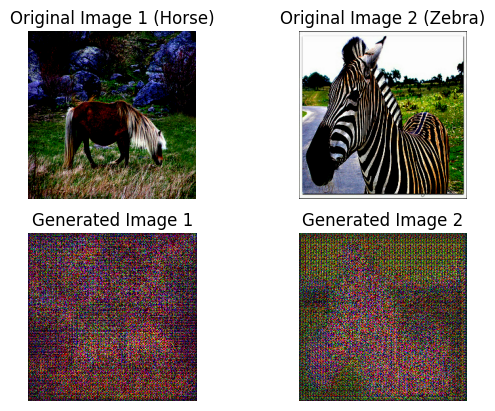

In [ ]:
plt.subplot(2, 2, 1)
plt.imshow(train_horses_preprocessed[39])
plt.title('Original Image 1 (Horse)')
plt.axis('off')


plt.subplot(2, 2, 2)
plt.imshow(train_zebras_preprocessed[72])
plt.title('Original Image 2 (Zebra)')
plt.axis('off')


image_1 = train_horses_preprocessed[39]
image_2 = train_zebras_preprocessed[72]

image_1 = tf.expand_dims(image_1, axis=0)
image_2 = tf.expand_dims(image_2, axis=0)

generated_image_1 = generator_g(image_1, training=False)[0]
generated_image_2 = generator_f(image_2, training=False)[0]

plt.subplot(2, 2, 3)
plt.imshow(generated_image_1.numpy())
plt.title('Generated Image 1')
plt.axis('off')


plt.subplot(2, 2, 4)
plt.imshow(generated_image_2.numpy())
plt.title('Generated Image 2')
plt.axis('off')


plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the trained models to Google Drive
generator_g.save('/content/drive/My Drive/model/generator_g_trained_q1.h5')
generator_f.save('/content/drive/My Drive/model/generator_f_trained_q1.h5')
discriminator_x.save('/content/drive/My Drive/model/discriminator_x_trained_q1.h5')
discriminator_y.save('/content/drive/My Drive/model/discriminator_y_trained_q1.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Q2) What would happen if you were to change the loss_obj object which is currently an instance of TensorFlow's BinaryCrossentropy class, and then train the GAN, how would the results differ, and why? Please do the following:

1. Train the GAN with the 1/4 the dataset.
2. chnage the BCE loss to somehting other relevant loss.
2. run till 10 epochs.
2. Generate images using this newly trained model
3. Along with a couple of images give reasoning for the results, as well as a description of the results, and how they differ to part 1s answer

Ans: The results are silghtly worse than those in q1, bcz Using MSE instead of  BCE could result in worse outcomes because MSE is more sensitive to pixel-level differences and may not capture the overall image distribution as effectively as BCE, leading to poorer  results.

In [ ]:
loss_obj = tf.keras.losses.MeanSquaredError()

quarter_size = len(train_horses_preprocessed) // 4
train_horses_quarter = train_horses_preprocessed[:quarter_size]
train_zebras_quarter = train_zebras_preprocessed[:quarter_size]

train_horses_dataset_quarter = tf.data.Dataset.from_tensor_slices(train_horses_quarter)
train_zebras_dataset_quarter = tf.data.Dataset.from_tensor_slices(train_zebras_quarter)


train_horses_dataset_quarter = train_horses_dataset_quarter.batch(BATCH_SIZE)
train_zebras_dataset_quarter = train_zebras_dataset_quarter.batch(BATCH_SIZE)

# declare the generators
generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# declare the discriminators
discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
test_input = next(test_horses_iter)

# Train the GAN
EPOCHS = 10
for epoch in range(EPOCHS):
    # code for executing the loop should go here

    for (real_x, real_y) in zip(train_horses_dataset_quarter, train_zebras_dataset_quarter):
        # print(real_y)
        gen_g, gen_f, disc_x, disc_y = train_step(real_x, real_y)

    print("Epoch : ", epoch, "  Loss_gen_g : ", gen_g, "  Loss_gen_f : ", gen_f, "  Loss_disc_x : ", disc_x, "  Loss_disc_y : ", disc_y)

    # if EPOCHS % 2 == 0:

    #     generated_image = generate_images(generator_g, test_input)


Epoch :  0   Loss_gen_g :  tf.Tensor(10.295443, shape=(), dtype=float32)   Loss_gen_f :  tf.Tensor(6.71212, shape=(), dtype=float32)   Loss_disc_x :  tf.Tensor(0.65434635, shape=(), dtype=float32)   Loss_disc_y :  tf.Tensor(0.048220985, shape=(), dtype=float32)
Epoch :  1   Loss_gen_g :  tf.Tensor(9.809559, shape=(), dtype=float32)   Loss_gen_f :  tf.Tensor(6.665199, shape=(), dtype=float32)   Loss_disc_x :  tf.Tensor(0.5833166, shape=(), dtype=float32)   Loss_disc_y :  tf.Tensor(0.05750353, shape=(), dtype=float32)
Epoch :  2   Loss_gen_g :  tf.Tensor(9.485113, shape=(), dtype=float32)   Loss_gen_f :  tf.Tensor(6.6340847, shape=(), dtype=float32)   Loss_disc_x :  tf.Tensor(0.5817314, shape=(), dtype=float32)   Loss_disc_y :  tf.Tensor(0.075946614, shape=(), dtype=float32)
Epoch :  3   Loss_gen_g :  tf.Tensor(10.221211, shape=(), dtype=float32)   Loss_gen_f :  tf.Tensor(6.71855, shape=(), dtype=float32)   Loss_disc_x :  tf.Tensor(0.6279017, shape=(), dtype=float32)   Loss_disc_y :  tf.

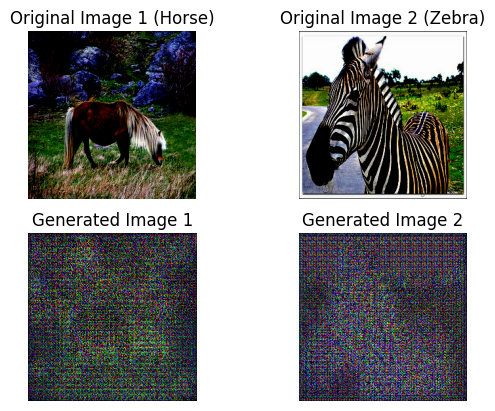

In [ ]:
plt.subplot(2, 2, 1)
plt.imshow(train_horses_preprocessed[39])
plt.title('Original Image 1 (Horse)')
plt.axis('off')


plt.subplot(2, 2, 2)
plt.imshow(train_zebras_preprocessed[72])
plt.title('Original Image 2 (Zebra)')
plt.axis('off')


image_1 = train_horses_preprocessed[39]
image_2 = train_zebras_preprocessed[72]

image_1 = tf.expand_dims(image_1, axis=0)
image_2 = tf.expand_dims(image_2, axis=0)

generated_image_1 = generator_g(image_1, training=False)[0]
generated_image_2 = generator_f(image_2, training=False)[0]

plt.subplot(2, 2, 3)
plt.imshow(generated_image_1.numpy())
plt.title('Generated Image 1')
plt.axis('off')


plt.subplot(2, 2, 4)
plt.imshow(generated_image_2.numpy())
plt.title('Generated Image 2')
plt.axis('off')


plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the trained models to Google Drive
generator_g.save('/content/drive/My Drive/model/generator_g_trained_q2.h5')
generator_f.save('/content/drive/My Drive/model/generator_f_trained_q2.h5')
discriminator_x.save('/content/drive/My Drive/model/discriminator_x_trained_q2.h5')
discriminator_y.save('/content/drive/My Drive/model/discriminator_y_trained_q2.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Q3) What would happen if you were to add noise to the images of horses, add noise of coming from a random noise distribution to all horse images, and then train the GAN, how would the results differ, and why? Please do the following:

1. Take 1/4 the dataset, and add noise to the images of only horses.
2. Train the GAN with this 1/4 the dataset.
3. run till 10 epochs.
4. Generate images using this newly trained model
5. Along with a couple of images give reasoning for the results, as well as a description of the results, and how they differ to part 1's answer

In [ ]:
def add_noise(image):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=.5)
    noisy_image = image + noise
    return noisy_image

noisy_train_horses = []
for image in train_horses_preprocessed[:quarter_size]:
    noisy_image = add_noise(image)
    noisy_train_horses.append(noisy_image)

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

quarter_size = len(train_horses_preprocessed) // 4
train_horses_quarter = train_horses_preprocessed[:quarter_size]
train_zebras_quarter = train_zebras_preprocessed[:quarter_size]

noisy_train_horses_dataset_quarter = tf.data.Dataset.from_tensor_slices(noisy_train_horses)
train_zebras_dataset_quarter = tf.data.Dataset.from_tensor_slices(train_zebras_quarter)

train_horses_dataset_quarter = noisy_train_horses_dataset_quarter.batch(BATCH_SIZE)
train_zebras_dataset_quarter = train_zebras_dataset_quarter.batch(BATCH_SIZE)

# declare the generators
generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# declare the discriminators
discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
test_input = next(test_horses_iter)

EPOCHS = 10
for epoch in range(EPOCHS):
    # code for executing the loop should go here

    for (real_x, real_y) in zip(train_horses_dataset_quarter, train_zebras_dataset_quarter):
        # print(real_y)
        gen_g, gen_f, disc_x, disc_y = train_step(real_x, real_y)

    print("Epoch : ", epoch, "  Loss_gen_g : ", gen_g, "  Loss_gen_f : ", gen_f, "  Loss_disc_x : ", disc_x, "  Loss_disc_y : ", disc_y)

    # if EPOCHS % 2 == 0:

    #     generated_image = generate_images(generator_g, test_input)


Epoch :  0   Loss_gen_g :  tf.Tensor(11.640066, shape=(), dtype=float32)   Loss_gen_f :  tf.Tensor(11.530284, shape=(), dtype=float32)   Loss_disc_x :  tf.Tensor(0.44828415, shape=(), dtype=float32)   Loss_disc_y :  tf.Tensor(0.22909275, shape=(), dtype=float32)
Epoch :  1   Loss_gen_g :  tf.Tensor(13.406082, shape=(), dtype=float32)   Loss_gen_f :  tf.Tensor(11.599442, shape=(), dtype=float32)   Loss_disc_x :  tf.Tensor(0.48245537, shape=(), dtype=float32)   Loss_disc_y :  tf.Tensor(0.06571854, shape=(), dtype=float32)
Epoch :  2   Loss_gen_g :  tf.Tensor(13.351121, shape=(), dtype=float32)   Loss_gen_f :  tf.Tensor(11.825763, shape=(), dtype=float32)   Loss_disc_x :  tf.Tensor(0.55515575, shape=(), dtype=float32)   Loss_disc_y :  tf.Tensor(0.058689777, shape=(), dtype=float32)
Epoch :  3   Loss_gen_g :  tf.Tensor(14.100958, shape=(), dtype=float32)   Loss_gen_f :  tf.Tensor(11.608192, shape=(), dtype=float32)   Loss_disc_x :  tf.Tensor(0.46853617, shape=(), dtype=float32)   Loss_disc

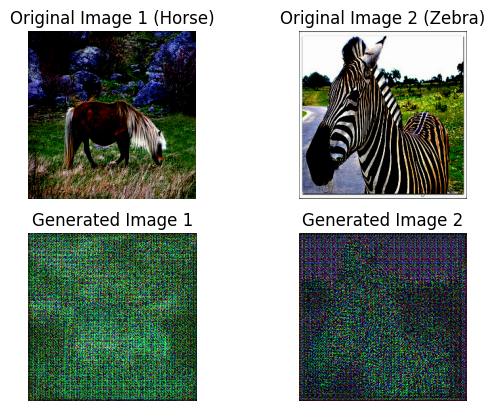

In [ ]:
plt.subplot(2, 2, 1)
plt.imshow(train_horses_preprocessed[39])
plt.title('Original Image 1 (Horse)')
plt.axis('off')


plt.subplot(2, 2, 2)
plt.imshow(train_zebras_preprocessed[72])
plt.title('Original Image 2 (Zebra)')
plt.axis('off')


image_1 = train_horses_preprocessed[39]
image_2 = train_zebras_preprocessed[72]

image_1 = tf.expand_dims(image_1, axis=0)
image_2 = tf.expand_dims(image_2, axis=0)

generated_image_1 = generator_g(image_1, training=False)[0]
generated_image_2 = generator_f(image_2, training=False)[0]

plt.subplot(2, 2, 3)
plt.imshow(generated_image_1.numpy())
plt.title('Generated Image 1')
plt.axis('off')


plt.subplot(2, 2, 4)
plt.imshow(generated_image_2.numpy())
plt.title('Generated Image 2')
plt.axis('off')


plt.show()


Ans:
Adding noise to the images increases the loss bcz it introduces additional random variations, making it harder for the model to capture  patterns.